In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import os
import time
import gc
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV

In [14]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [15]:
from xgboost import plot_importance
from matplotlib import pyplot


# Load csv data into memory

In [54]:
missing_values = ["n/a", "na", "--", "None", "nan"]

In [55]:
flight_shopping = pd.read_csv("flight_shopping_10_percent.csv", na_values = missing_values)

In [18]:
flight_shopping.shape

(4235, 8)

# Preprocessing

In [19]:
flight_shopping = flight_shopping[((flight_shopping['sum(estimated_time)'] - flight_shopping['sum(estimated_time)'].mean()) / flight_shopping['sum(estimated_time)'].std()).abs() < 3]

In [20]:
flight_shopping.shape

(4191, 8)

In [57]:
flight_shopping.head()

,Gate,Arrival,Date,Schedule_Depart_Time,Actual_Depart_Time,Actual_Arrival_Time,Flying_Hours,sum(estimated_time)
0,C44,Bogota,10/18/2019,6.5,7.316667,11:39,6:20,1705.395432
1,C44,Bogota,10/19/2019,6.5,6.683333,10:53,6:12,6722.978906
2,C44,Bogota,10/20/2019,6.5,7.266667,11:31,6:15,16.548587
3,C44,Bogota,10/21/2019,6.5,6.916667,11:31,6:36,4451.408472
4,C44,Bogota,10/23/2019,6.5,7.850000,12:25,6:34,9134.047758


In [22]:
et_low = flight_shopping['sum(estimated_time)'].quantile(0.2)
et_high = flight_shopping['sum(estimated_time)'].quantile(0.75)

flight_shopping = flight_shopping[(flight_shopping['sum(estimated_time)']<et_high)&(flight_shopping['sum(estimated_time)']>et_low)]

In [23]:
et_low

2815.4744703399897

Text(0, 0.5, 'Flights')

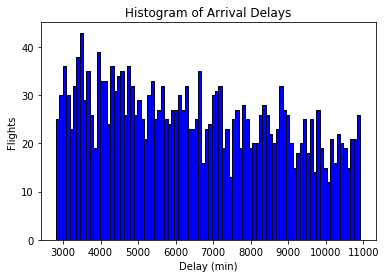

In [24]:
plt.hist(flight_shopping['sum(estimated_time)'], color = 'blue', edgecolor = 'black',
         bins = int(9000/100))

# seaborn histogram
sns.distplot(flight_shopping['sum(estimated_time)'], hist=True, kde=False, 
             bins=int(9000/100), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Arrival Delays')
plt.xlabel('Delay (min)')
plt.ylabel('Flights')

In [25]:
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()

NameError: name 'N' is not defined

In [26]:
flight_shopping.shape

(2304, 8)

In [27]:
train_x = flight_shopping[['Gate', 'Arrival', 'Date', 'Schedule_Depart_Time', 'Flying_Hours']]

In [28]:
train_x.head()

,Gate,Arrival,Date,Schedule_Depart_Time,Flying_Hours
1,C44,Bogota,10/19/2019,6.500000,6:12
3,C44,Bogota,10/21/2019,6.500000,6:36
4,C44,Bogota,10/23/2019,6.500000,6:34
6,C44,Bogota,12/20/2019,6.416667,6:11
7,C44,Buenos Aires,10/10/2019,7.583333,3:35


In [29]:
train_y = flight_shopping[['sum(estimated_time)']]

In [30]:
train_y.head()

,sum(estimated_time)
1,6722.978906
3,4451.408472
4,9134.047758
6,8665.250886
7,4323.170957


In [31]:
train_x.isnull().sum()

Gate                     0
Arrival                  0
Date                     0
Schedule_Depart_Time     0
Flying_Hours            57
dtype: int64

In [37]:
def hour_convert(x):
    if type(x) == str:
        h,m = map(int,x.split(':'))
        return (h*60+m)
    else:
        print(type(x))
        print(x)
        return x
    
def fill_0(x):
    if x == 0:
        x = 445.63260525617636

    return x

def hr_min(x):
    return x*60

In [36]:
train_x.Flying_Hours.mean()

445.63260525617636

In [34]:
train_x.Flying_Hours = train_x.Flying_Hours.fillna('0:0')
train_x.Flying_Hours = train_x.Flying_Hours.apply(hour_convert)

/Users/ziluli/anaconda3/envs/elo/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [38]:
train_x.Flying_Hours = train_x.Flying_Hours.apply(fill_0)

In [39]:
train_x.Schedule_Depart_Time = train_x.Schedule_Depart_Time.apply(hr_min)
# train_x.Actual_Depart_Time = train_x.Actual_Depart_Time.apply(hr_min)

In [40]:
train_y['sum(estimated_time)'] = train_y['sum(estimated_time)'].fillna(train_y['sum(estimated_time)'].mean())

/Users/ziluli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [41]:
train_x.head()

,Gate,Arrival,Date,Schedule_Depart_Time,Flying_Hours
1,C44,Bogota,10/19/2019,390.0,372.0
3,C44,Bogota,10/21/2019,390.0,396.0
4,C44,Bogota,10/23/2019,390.0,394.0
6,C44,Bogota,12/20/2019,385.0,371.0
7,C44,Buenos Aires,10/10/2019,455.0,215.0


In [42]:
train = flight_shopping

In [43]:
train_x['Date'] = pd.to_datetime(train_x['Date'], errors='coerce')

/Users/ziluli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [44]:
def sec_min(x):
    return x/60

In [45]:
train_y = train_y.apply(sec_min)

In [46]:
train_y.head()

,sum(estimated_time)
1,112.049648
3,74.190141
4,152.234129
6,144.420848
7,72.052849


# Data Transformation

In [47]:
def time_convert(x):
    h,m = map(int,x.split(':'))
    return (h*60+m)

def aggregate_nmt(train):
    train['year'] = train['Date'].dt.year
    train['weekofyear'] = train['Date'].dt.weekofyear
    train['month'] = train['Date'].dt.month
    train['dayofweek'] = train['Date'].dt.dayofweek

    train.loc[:, 'Date'] = pd.DatetimeIndex(train['Date']).astype(np.int64) * 1e-9

    train = pd.get_dummies(train, columns=['Gate', 'Arrival'])

    return train

In [48]:
train_x = aggregate_nmt(train_x)

/Users/ziluli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/ziluli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [49]:
train_x.head()

,Date,Schedule_Depart_Time,Flying_Hours,year,weekofyear,month,dayofweek,Gate_C44,Gate_C45,Gate_C46,...,Arrival_New York,Arrival_Panama City,Arrival_Paris,Arrival_Porto,Arrival_Recife,Arrival_Rome,Arrival_Rosario,Arrival_Salvador,Arrival_Santiago,Arrival_Zurich
1,1.571443e+09,390.0,372.0,2019,42,10,5,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.571616e+09,390.0,396.0,2019,43,10,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.571789e+09,390.0,394.0,2019,43,10,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1.576800e+09,385.0,371.0,2019,51,12,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1.570666e+09,455.0,215.0,2019,41,10,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
train_x.columns

Index(['Date', 'Schedule_Depart_Time', 'Flying_Hours', 'year', 'weekofyear',
       'month', 'dayofweek', 'Gate_C44', 'Gate_C45', 'Gate_C46', 'Gate_C47',
       'Gate_C48', 'Gate_C49', 'Gate_C50', 'Gate_C51', 'Gate_C52', 'Gate_C53',
       'Gate_C54', 'Gate_C55', 'Gate_C56', 'Gate_C57', 'Gate_C58', 'Gate_C59',
       'Gate_C60', 'Gate_C61', 'Gate_C62', 'Gate_C63', 'Gate_C64', 'Gate_C65',
       'Gate_C66', 'Gate_C67', 'Gate_C69', 'Arrival_Amsterdam',
       'Arrival_Atlanta', 'Arrival_Bogota', 'Arrival_Buenos Aires',
       'Arrival_Campinas', 'Arrival_Casablanca', 'Arrival_Cordoba',
       'Arrival_Doha', 'Arrival_Dubai', 'Arrival_Frankfurt', 'Arrival_Houston',
       'Arrival_Lima', 'Arrival_Lisbon', 'Arrival_London', 'Arrival_Luanda',
       'Arrival_Madrid', 'Arrival_Miami', 'Arrival_Montevideo',
       'Arrival_New York', 'Arrival_Panama City', 'Arrival_Paris',
       'Arrival_Porto', 'Arrival_Recife', 'Arrival_Rome', 'Arrival_Rosario',
       'Arrival_Salvador', 'Arrival_Santiago

In [144]:
test_x = train_x.tail()

# Train Model

In [145]:
def kfold_lightgbm(train_df, test_df, y, num_folds, stratified = False, debug= False):
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=17)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=17)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = train_df.columns.tolist()
#     test_df = test_df[feats]
    #test_df = csr_matrix(test_df)
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, y)):
        print('FOLD {}'.format(n_fold))
        train_x, train_y = train_df.iloc[train_idx], y.iloc[train_idx]
        valid_x, valid_y = train_df.iloc[valid_idx], y.iloc[valid_idx]
        lgb_params =  {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            #"n_estimators":10000,
            "learning_rate": 0.01,
             
            'num_leaves': 60,
            'subsample': 0.6143,
            'colsample_bytree': 0.6453,
            'min_split_gain': np.power(10, -2.5988),
            'reg_alpha': np.power(10, -2.2887),
            'reg_lambda': np.power(10, 1.7570),
            'min_child_weight': np.power(10, -0.1477),
            'max_depth': -1,
            #'zero_as_missing':True
        }
        lgb_params = {
         'task': 'train',
         'num_leaves': 54,
         'min_data_in_leaf': 79,
         'objective': 'regression',
         'max_depth': 15,
         'learning_rate': 0.018545526395058548,
         "boosting": "gbdt",
         "feature_fraction": 0.8354507676881442,
         "bagging_freq": 3,
         "bagging_fraction": 0.8126672064208567,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         'min_child_weight': 5.343384366323818,
         'reg_alpha': 1.1302650970728192,
         'reg_lambda': 0.3603427518866501,
         'subsample': 0.8767547959893627,}
        #train_x = csr_matrix(train_x)
        #valid_x = csr_matrix(valid_x)
        lgtrain = lgb.Dataset(train_x, train_y)
        lgvalid = lgb.Dataset(valid_x, valid_y)
        clf = lgb.train(
            lgb_params,
            lgtrain,
            num_boost_round=3000,
            valid_sets=[lgtrain, lgvalid],
            valid_names=['train','valid'],
            early_stopping_rounds=200,
            verbose_eval=100
        )
         
        oof_preds[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration)
        sub_preds += clf.predict(test_df, num_iteration=clf.best_iteration)/ folds.n_splits
        print(len(feats))
        print(len(clf.feature_importance()))
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importance()
        #fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        #print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        print('Fold %2d RMSE : %.6f' % (n_fold, np.sqrt(metrics.mean_squared_error(valid_y, oof_preds[valid_idx]))))      
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()
 
    rmse = np.sqrt(metrics.mean_squared_error(y, oof_preds))
    #print('Full AUC score %.6f' % roc_auc_score(y, oof_preds))
    print('Full RMSE score %.6f' % rmse)
     
    display_importances(feature_importance_df)
    return feature_importance_df, sub_preds

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgb_importances.png')

FOLD 0
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 34.8548	valid's rmse: 35.8825
[200]	train's rmse: 33.6125	valid's rmse: 35.3892
[300]	train's rmse: 32.8144	valid's rmse: 35.161
[400]	train's rmse: 32.1532	valid's rmse: 34.971
[500]	train's rmse: 31.5953	valid's rmse: 34.8783
[600]	train's rmse: 31.0869	valid's rmse: 34.851
[700]	train's rmse: 30.6297	valid's rmse: 34.8227
[800]	train's rmse: 30.21	valid's rmse: 34.8093
[900]	train's rmse: 29.8268	valid's rmse: 34.702
[1000]	train's rmse: 29.4487	valid's rmse: 34.7038
[1100]	train's rmse: 29.1273	valid's rmse: 34.6371
[1200]	train's rmse: 28.786	valid's rmse: 34.6989
Early stopping, best iteration is:
[1098]	train's rmse: 29.1328	valid's rmse: 34.632
60
60
Fold  0 RMSE : 34.632000
FOLD 1
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 34.7654	valid's rmse: 36.628
[200]	train's rmse: 33.4476	valid's rmse: 36.1058
[300]	train's rmse: 32.6289	valid's rmse: 35.9785

/Users/ziluli/anaconda3/envs/elo/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


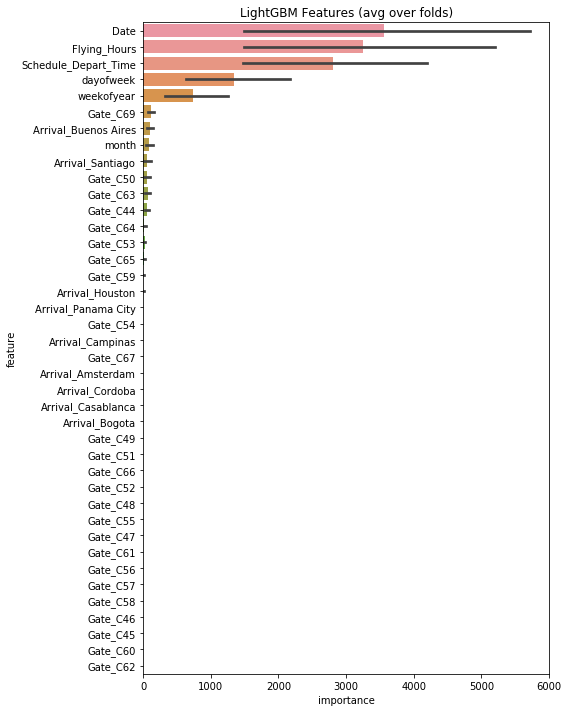

In [146]:
feature_importance_df, sub_preds = kfold_lightgbm(train_x, test_x, train_y, 4, stratified = False, debug= False)

In [106]:
sub_preds

array([120.16680371,  49.27688007,  57.71719863, 123.29316197,
        42.40110211])

In [107]:
test_y

,sum(estimated_time)
4236,109.641683
4237,45.162939
4238,54.736363
4239,161.718970
4240,32.052955


In [147]:
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(train_x,
         train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:   10.4s finished


-0.04675769327294432
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [155]:

best_parameters = {'colsample_bytree': 0.7, 
 'learning_rate': 0.03, 
 'max_depth': 6, 
 'min_child_weight': 4, 
 'n_estimators': 500, 
 'nthread': 4, 
 'objective': 'reg:linear', 
 'subsample': 0.7}

In [156]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 20))

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

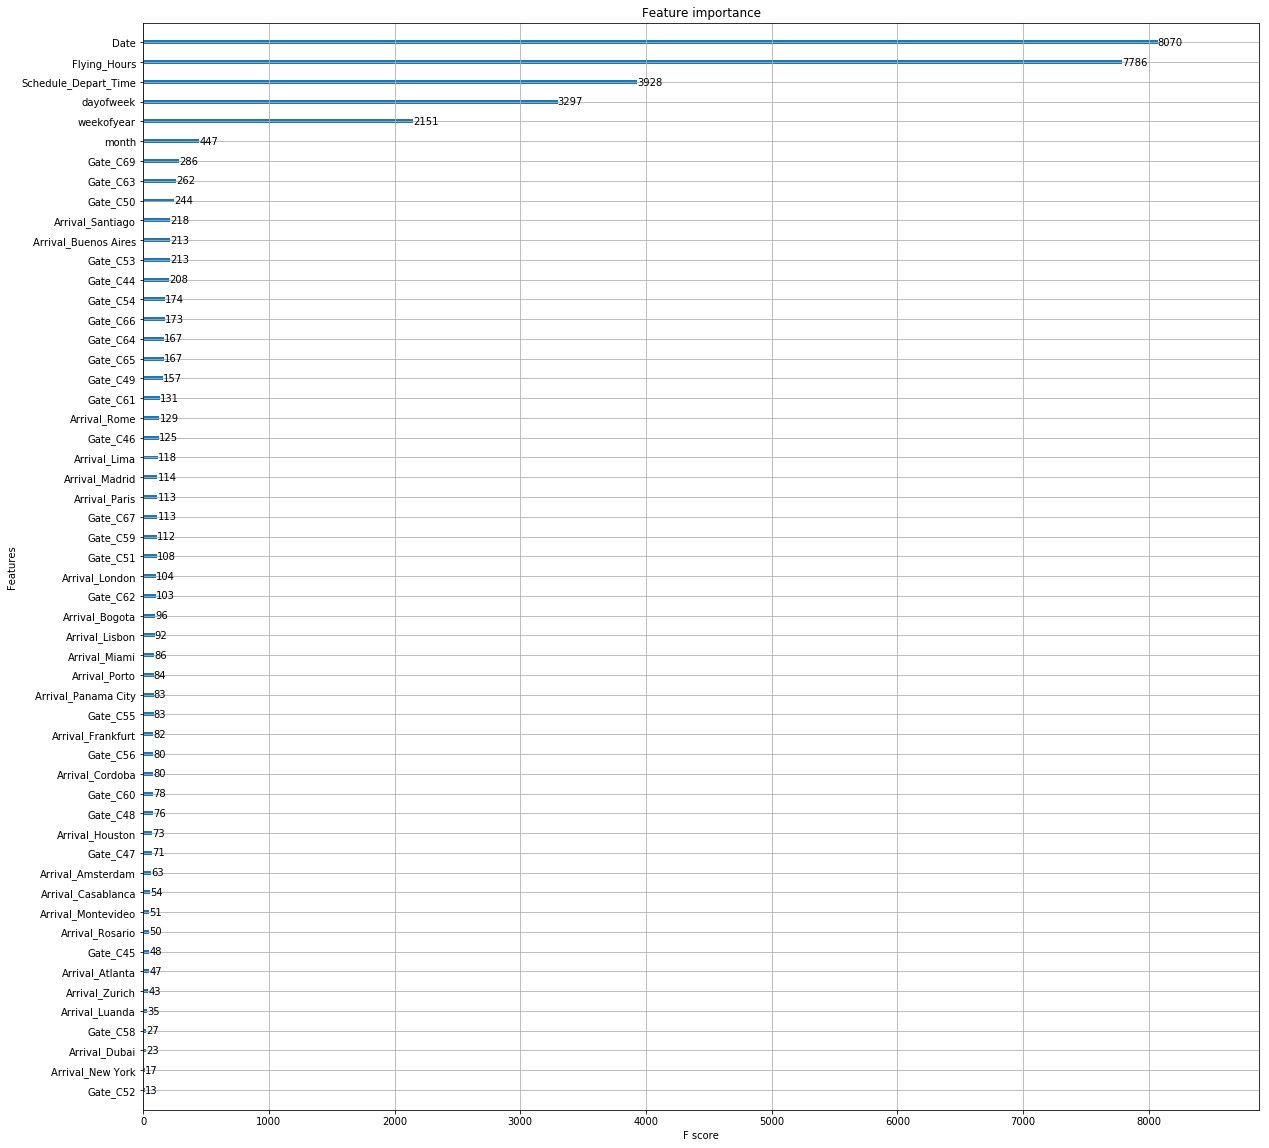

In [157]:
num_rounds = 1000

dtrain = xgb.DMatrix(train_x, label=train_y)
gbdt = xgb.train(best_parameters, dtrain, num_rounds)

ax = plot_importance(gbdt)
fig = ax.figure
fig.set_size_inches(20, 20)
pyplot.show()

In [51]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
import math

In [52]:
num_rounds = 1000
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.1, random_state=7)
model = XGBRegressor(colsample_bytree= 0.7, 
 learning_rate=0.03, 
 max_depth=7, 
 min_child_weight=4, 
 n_estimators=500, 
 nthread=4, 
 objective='reg:linear', 
 subsample=0.7,
 num_boost_round=1000,
 verbose = 1,)
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
mse = mean_squared_error(y_test, predictions)
print("rmse: "+ str(math.sqrt(mse)))

[15:34:58] WARNING: /private/var/folders/lt/4lw1z7fx2bg3wv2cw19j9h5m0000gn/T/pip-install-8i90zoj8/xgboost/xgboost/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
rmse: 33.97818191886594


In [53]:
import pickle
file_name = "xgb_reg.pkl"
pickle.dump(model, open(file_name, "wb"))


In [153]:
model.get_booster()

In [154]:
y_pred_ = model.predict(X_train)
predictions_ = [round(value) for value in y_pred_]
mse_ = mean_squared_error(y_train, predictions_)
print("rmse: "+ str(math.sqrt(mse_)))

rmse: 19.451461473851474


In [ ]:
import pickle
filename = 'xgboost_model.sav'
pickle.dump(model, open(filename, 'wb'))


In [70]:
class MyXGBRegressor(XGBRegressor):
	@property
	def coef_(self):
		return None

In [72]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.1, random_state=7)
model = MyXGBRegressor(colsample_bytree= 0.7, 
 learning_rate=0.03, 
 max_depth=7, 
 min_child_weight=4, 
 n_estimators=500, 
 nthread=4, 
 objective='reg:linear', 
 silent=1, 
 subsample=0.7)
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
mse = mean_squared_error(y_test, predictions)
print("rmse: "+ str(math.sqrt(mse)))
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBRegressor()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    mse = mean_squared_error(y_test, predictions)
    print("Thresh=%.3f, n=%d, rmse: %.2f" % (thresh, select_X_train.shape[1], math.sqrt(mse)))

rmse: 48.59812268877009
Thresh=0.000, n=62, rmse: 51.31
Thresh=0.000, n=62, rmse: 51.31
Thresh=0.000, n=62, rmse: 51.31
Thresh=0.000, n=62, rmse: 51.31
Thresh=0.000, n=62, rmse: 51.31
Thresh=0.003, n=57, rmse: 51.31
Thresh=0.004, n=56, rmse: 51.86
Thresh=0.008, n=55, rmse: 51.65
Thresh=0.009, n=54, rmse: 51.65
Thresh=0.009, n=53, rmse: 51.65
Thresh=0.010, n=52, rmse: 51.10
Thresh=0.010, n=51, rmse: 50.76
Thresh=0.010, n=50, rmse: 50.20
Thresh=0.011, n=49, rmse: 51.24
Thresh=0.012, n=48, rmse: 50.36
Thresh=0.012, n=47, rmse: 51.22
Thresh=0.012, n=46, rmse: 50.49
Thresh=0.012, n=45, rmse: 51.77
Thresh=0.013, n=44, rmse: 50.47
Thresh=0.013, n=43, rmse: 51.34
Thresh=0.013, n=42, rmse: 51.46
Thresh=0.013, n=41, rmse: 50.38
Thresh=0.014, n=40, rmse: 50.60
Thresh=0.014, n=39, rmse: 51.08
Thresh=0.014, n=38, rmse: 49.03
Thresh=0.014, n=37, rmse: 49.68
Thresh=0.014, n=36, rmse: 49.03
Thresh=0.014, n=35, rmse: 49.29
Thresh=0.014, n=34, rmse: 48.34
Thresh=0.014, n=33, rmse: 49.77
Thresh=0.014, n=

In [69]:
def train_model(X=X_train, X_test=X_test, y=y, params=None, folds=kfolds, model_type='lgb', plot_feature_importance=False):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            ###  rfecv  ###
            selector = RFECV(estimator=model, cv=3)
            selector.fit(X_train, y_train)
            Good_features = []
            #get pruned set of features' list
            for i in range(len(selector.support_)):
                if selector.support_[i]==True:
                    Good_features.append(i)
            model.fit(X_train[X_train.columns[Good_features]], y_train, 
                    eval_set=[(X_train[X_train.columns[Good_features]], y_train), (X_valid[X_valid.columns[Good_features]], y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)
            y_pred_valid = model.predict(X_valid[X_valid.columns[Good_features]])
            y_pred = model.predict(X_test[X_test.columns[Good_features]], num_iteration=model.best_iteration_)
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred  
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

NameError: name 'y' is not defined

In [5]:
params = {'num_leaves': 54,
         'min_data_in_leaf': 79,
         'objective': 'regression',
         'max_depth': 15,
         'learning_rate': 0.018545526395058548,
         "boosting": "gbdt",
         "feature_fraction": 0.8354507676881442,
         "bagging_freq": 3,
         "bagging_fraction": 0.8126672064208567,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         'min_child_weight': 5.343384366323818,
         'reg_alpha': 1.1302650970728192,
         'reg_lambda': 0.3603427518866501,
         'subsample': 0.8767547959893627,}